# CS5489 - Machine Learning
# Lecture 8a - Neural Networks
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- History
- Perceptron
- Multi-class logistic regression
- Multi-layer perceptron (MLP)


In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

rbow = plt.get_cmap('rainbow')

# Original idea
- _Perceptron_ 
  - Warren McCulloch and Walter Pitts (1943), Rosenblatt (1957)
  - Simulate a neuron in the brain 
    - 1) take binary inputs (input from nearby neurons)
    - 2) multiply by weights (synapses, dendrites)
    - 3) sum and threshold to get binary output (output axon)
  - Train weights from data.
<center><table border=0><tr><td><img src="imgs/neuron.png" width=350></td><td><img src="imgs/neuron_model.jpeg" width=350></tr></table></center>


- Multiple outputs handled by using multiple perceptrons
<center><img src="imgs/multiout.jpg" width=200></center>

- **Problem:**
  - linear classifier, can't solve harder problems

# Multi-layer Perceptron
- Add _hidden_ layers between input and output neurons
  - each layer extracts some features from the previous layers
  - can represent complex non-linear functions 
  - train weights using _backpropagation_ algorithm. (1970-80s)
  - (now called a _neural network_)
<center><table border=0><tr><td><img src="imgs/neural_net.jpeg" width=350></td><td><img src="imgs/neural_net2.jpeg" width=350></tr></table></center>



- **Problem:**
  - difficult to train.
  - sensitive to initialization.
  - computationally expensive (at the time).


# Decline in the 1990s
- Because of those problems, NN became less popular in the 1990s
  - Support vector machines (SVM) had good accuracy
    - easy to use - only one global optimum.
    - learning is not sensitive to initialization.
    - theory about generalization guarantees.
  - Not a lot of data, so kernel methods were still okay.

# Deep learning
- There was a resurgence in NN in the 2000s, due to a number of factors:
  - improvements in network architecture
    - developed nodes that are easier to train
  - better training algorithms
    - better ways to prevent overfitting
    - better initialization methods
  - faster computers
    - massively parallel GPUs
  - more labeled data
    - from Internet
    - crowd-sourcing for labeling data (Amazon Turk)    

- We can train NN with more and more layers $\Rightarrow$ Deep Learning
<center><img src="imgs/bg_pipeline-01.png" width="100%"></center>

In [2]:
def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, col='k', ls='-', label=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c is not None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    if (poscol) or (negcol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)
    
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        f = sum(w*[polyx[2], polyy[2]])+b
        if (f>0) and (poscol):
            plt.fill(polyx, polyy, poscol, alpha=0.2)
        if (f<0) and (negcol):
            plt.fill(polyx, polyy, negcol, alpha=0.2)

    # plot line
    plt.plot(x0, x1, col+ls, lw=lw, label=label)

    # the w
    if (wlabel is not None):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], head_width=0.4,  width=0.01, linestyle=ls, edgecolor=col, facecolor=col)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)

def plot_perceptron(wb, X, Y, axbox, curn=None, wb_old=None):
    if wb_old is None:
        label1 = 'w'
    else:
        label1 = 'new w'
        label2 = 'old w'
    drawplane(wb[0], wb[1], wlabel="", label=label1)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
    if curn is not None:
        plt.plot(X[curn,0], X[curn,1], 'ko', fillstyle='none', markeredgewidth=2, label='selected point')
    if wb_old is not None:
        drawplane(wb_old[0], wb_old[1], lw=1, col='r', ls="--", label=label2)
    plt.grid(True)
    plt.axis(axbox)

In [3]:
# generate random data
X,Y = datasets.make_blobs(n_samples=50, 
         centers=array([[2,5], [-2,-3.2]]), cluster_std=2, n_features=2, 
         random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

lsdatafig = plt.figure()   
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
axbox = [-10,10,-10,10]
plt.axis(axbox); plt.grid(True);
plt.close()

# Outline
- History
- **Perceptron**
- Multi-class logistic regression
- Multi-layer perceptron (MLP)

# Perceptron

- Model a single neuron
  - input $\mathbf{x}\in \mathbb{R}^d$ is a $d$-dim vector
  - apply a weight to the inputs
  - sum and threshold to get the output

- Formally,
  - $y = f( \sum_{j=0}^d w_j x_j) = f(\mathbf{w}^T\mathbf{x})$
  - $\mathbf{w}$ is the weight vector.
  - $f(a)$ is the activation function
    - $f(a) = \begin{cases}1, & a>0 \\ 0, & \text{otherwise}\end{cases}$
<center><img src="imgs/Perceptron.jpg" width=600></center>

# Perceptron training criteria
- Train the perceptron on data $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^N$
- Only look at the points that are misclassified.
  - Loss is based on how badly misclassified
  $$E(\mathbf{w}) = \sum_{i=1}^N \begin{cases} - y_i \mathbf{w}^T \mathbf{x}_i, & \mathbf{x}_i\text{ is misclassified} \\ 0, & \text{otherwise}\end{cases}$$
- Minimize the loss: $\mathbf{w}^* = \mathop{\mathrm{argmin}}_{\mathbf{w}} E(\mathbf{w})$

# Perceptron Loss Function
- Define $z_i = y_i \mathbf{w}^T\mathbf{x}_i$,
- The loss function is $$L(z_i) = \max(0,-z_i)$$

In [4]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
hingeloss = maximum(0, 1-z)
percloss = maximum(0,-z)
lossfig = plt.figure()

plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.plot(z,hingeloss, 'b-', label='hinge (SVM)')
plt.plot(z,logloss, 'r-', label='logistic (LR)')
plt.plot(z,percloss, 'c-', label='perceptron')
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.legend(loc='right')
plt.title('loss functions')
plt.close()

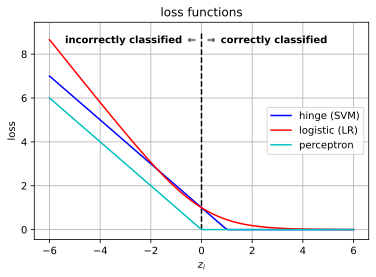

In [5]:
lossfig

# Training algorithm
- We can learn the model by applying gradient descent.
  - Move $\mathbf{w}$ in the direction to decrease the loss $E(\mathbf{w})$.
  - Gradient descent update: $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{d}{d\mathbf{w}} E(\mathbf{w})$
    - $\eta$ is the learning rate for gradient descent
<img src="imgs/graddescent.png" width=400>

- Computers were slow back then...
- Solution: only look at one data point at a time and use gradient descent.
  - loss of a misclassified point $\mathbf{x}_i$: $E_i(\mathbf{w}) =  - y_i \mathbf{w}^T \mathbf{x}_i$
  - Gradient: $\frac{d}{d\mathbf{w}} E_i(\mathbf{w}) = -y_i \mathbf{x}_i$

- **Perceptron Algorithm**
  - For each point $\mathbf{x}_i$, 
    - If the point $\mathbf{x}_i$ is misclassified,
      - Update weights: $\mathbf{w} \leftarrow \mathbf{w} + \eta y_i \mathbf{x}_i$
  - Repeat until no more points are misclassified

- **Notes:**
  - The effect of the update step is to rotate $\mathbf{w}$ towards the misclassified point $\mathbf{x}_i$.
  - This is called _Stochastic Gradient Descent_.
    - useful because we only need to look at a little bit of data at a time.
    - less computing/memory requirement in each iteration.

In [6]:
def run_perceptron(w_init, X, Y, iterfigs=False):
    w = w_init.copy()
    eta = 1.0

    figs=[]

    for t in range(10):
        # cycle through data points
        haserror = False
        for n in range(len(X)):
            yx = Y[n]*X[n]
            zp = sum(w*yx)
            if (zp<0):
                w_old = w.copy()
                w += eta*yx
                haserror = True
                if iterfigs:
                    figs.append(plt.figure(figsize=(10,4.5)))
                    plt.subplot(1,2,1)
                    plot_perceptron((w_old,0), X, Y, axbox, curn=n)
                    plt.legend(loc='best')
                    plt.subplot(1,2,2)
                    plot_perceptron((w,0), X, Y, axbox, curn=n, wb_old=(w_old,0))
                    plt.legend(loc='best')
                    plt.close()
        print(haserror)
        if not haserror:
            break

    if iterfigs:
        return (w, figs)
    else:
        return w

In [7]:
w,figs = run_perceptron(array([1.0, 0.01]), X, Y, iterfigs=True)

True
True
False


# Example
- Iteration 1
  - $\mathbf{w}$ rotates towards the misclassified point (bold circle)

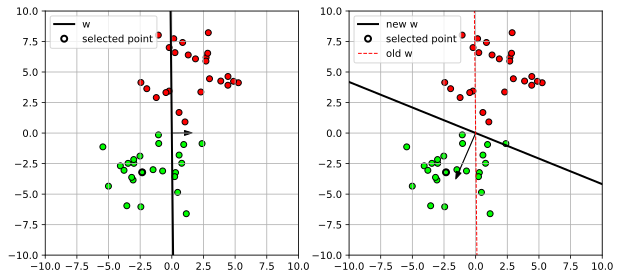

In [8]:
figs[0]

- Iteration 2

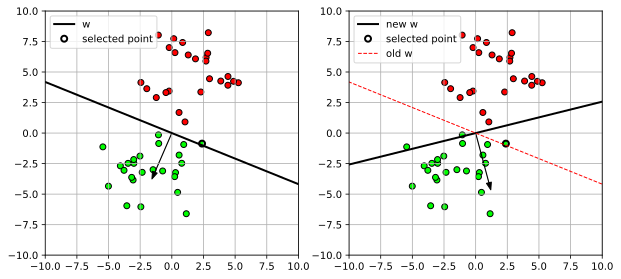

In [9]:
figs[1]

- Iteration 3

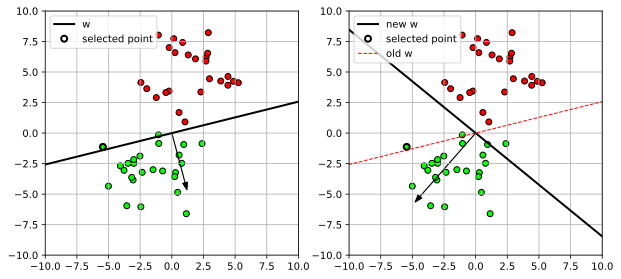

In [10]:
figs[2]

- Iteration 4
  - No more errors

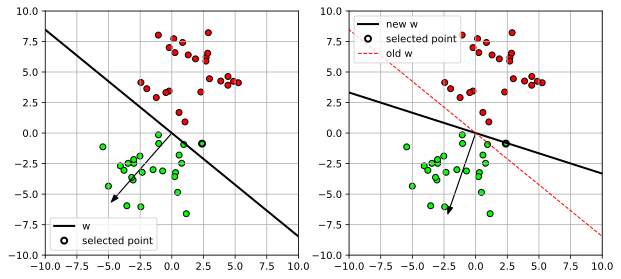

In [11]:
figs[3]

- Final classifier

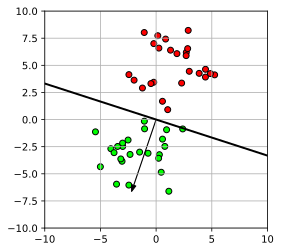

In [12]:
plt.figure(figsize=(4,4))
plot_perceptron((w,0),X,Y,axbox)

# Perceptron Algorithm
- Fails to converge if data is not linearly separable
- Rosenblatt proved that the algorithm will converge if the data is linearly separable.
  - the number of iterations is inversely proportional to the separation (margin) between classes.
  - _This was one of the first machine learning results!_

- Different initializations can yield different weights
  - There are multiple decision boundaries with 0 loss.

In [13]:
ni = random.permutation(arange(len(X)))
w2 = run_perceptron(array([1.0, 0.01]), X[ni], Y[ni])
ni = random.permutation(arange(len(X)))
w3 = run_perceptron(array([1.0, 0.01]), X[ni], Y[ni])
pfig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plot_perceptron((w,0),X,Y,axbox)
plt.subplot(1,3,2)
plot_perceptron((w2,0),X,Y,axbox)
plt.subplot(1,3,3)
plot_perceptron((w3,0),X,Y,axbox)
plt.close()

True
True
False
True
False


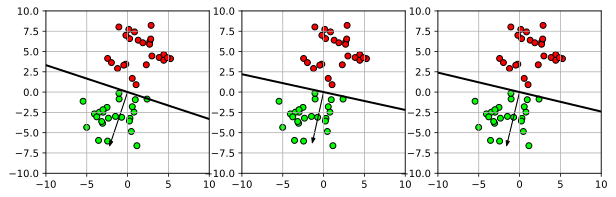

In [14]:
pfig

# Outline
- History
- Perceptron
- **Multi-class logistic regression**
- Multi-layer perceptron (MLP)

# Revisiting Multiclass logistic regression
- Consider a multi-class classification problem with $C$ classes
  - class labels $y\in \{1,\cdots,C\}$
  - equivalently, class vectors: 
  $$\mathbf{y} \in \{\begin{bmatrix}1\\0\\\vdots\\0\end{bmatrix},\begin{bmatrix}0\\1\\\vdots\\0\end{bmatrix},\cdots,\begin{bmatrix}0\\0\\\vdots\\1\end{bmatrix} \} = \{\mathbf{e}_1,\mathbf{e}_2,\cdots,\mathbf{e}_C\}$$
    - $\mathbf{e}_j$ is the canonical vector.


# Linear functions
- Construct $C$ linear functions, one for each class
  - $g_j(\mathbf{x}) = \mathbf{w}_j^T \mathbf{x}$, for $j=\{1,\cdots,C\}$
  - $\mathbf{w}_j$ is the weight vector for the j-th class.
  - (to reduce clutter, we implicitly include the bias term)
- Combine into a vector-valued function ($\mathbb{R}^C$):
  - $\mathbf{g}(\mathbf{x}) = \begin{bmatrix}g_1(\mathbf{x})\\\vdots\\g_C(\mathbf{x})\end{bmatrix} = \mathbf{W}^T 
  \mathbf{x}$, 
  - Weight matrix: $\mathbf{W} = [\mathbf{w}_1,\cdots,\mathbf{w}_C]$

# Mapping to probabilities
- output of $\mathbf{g}(\mathbf{x})$ is a real vector in $\mathbb{R}^C$.
- How to map it to set of class probabilities?
   - require $0\leq p(y=j|\mathbf{x}) \leq  1$ 
   - and $\sum_{j=1}^C p(y=j|\mathbf{x}) = 1$.

# Softmax function

- Given a real vector $\mathbf{a}\in\mathbb{R}^C$
- Let $s_j(\mathbf{a}) = \frac{\exp(a_j)}{\sum_{k=1}^C \exp(a_k)}$
  - if $a_j \gg a_i$, then the exponent will cause $s_j(\mathbf{a})\rightarrow 1$.
  - denominator ensures $\sum_{j=1}^C s_j(\mathbf{a})=1$.
- Let $\mathbf{s}(\mathbf{a}) = [s_1(\mathbf{a}) \cdots s_C(\mathbf{a})]^T$
  - the output vector is ~1 in the dimension of $\mathbf{a}$ with largest value, and 0 elsewhere.
  - called the **softmax** function ("soft" because the values can be between 0 and 1)

# Mapping to probabilities
- Define the probability of the j-th class $p(y=j|\mathbf{x})$ as:
  - $p(y=j|\mathbf{x}) = f_j(\mathbf{x}) = s_j(\mathbf{g}(\mathbf{x})) = \frac{\exp(g_j(\mathbf{x}))}{\sum_{k=1}^C \exp(g_k(\mathbf{x}))}$
    - if $g_j(\mathbf{x}) \gg g_i(\mathbf{x})$, then the exponent will cause numerator to be very large, and thus $p(y=j|\mathbf{x})\rightarrow 1$.
    - the class with largest response $g_j(\mathbf{x})$ will have highest probability.
    - denominator ensures probabilities sum to 1 over classes.
- Finally, define the posterior probability vector:
$$\begin{bmatrix}p(y=1|\mathbf{x})\\\vdots\\p(y=C|\mathbf{x})\end{bmatrix} = \mathbf{f}(\mathbf{x}) = \mathbf{s}(\mathbf{g}(\mathbf{x})))$$

# Example
- linear functions and mapped probabilities

In [15]:
x = linspace(-5,5,100)
w = array([-2, 0.5, 2])
b = array([0, 3, 0])

g = x[:,newaxis]*w+b

s = exp(g)
s /= sum(s,axis=1)[:,newaxis]

sfig = plt.figure()
plt.subplot(2,1,1)
plt.plot(x, g[:,0], label='$g_1(x)$')
plt.plot(x, g[:,1], label='$g_2(x)$')
plt.plot(x, g[:,2], label='$g_3(x)$')
plt.legend()
#plt.title('linear function')
plt.ylabel('$g_j(x)$')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(x, s[:,0], label='p(y=1|x)')
plt.plot(x, s[:,1], label='p(y=2|x)')
plt.plot(x, s[:,2], label='p(y=3|x)')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('p(y=j|x)')
#plt.title('probability')
plt.close()

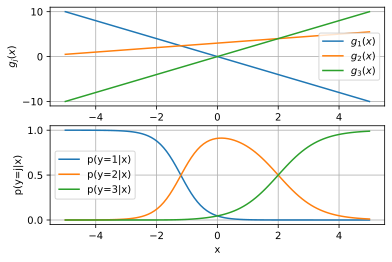

In [16]:
sfig

# Learning with MLE
- let $\mathbf{y}$ be the *class vector* representation of the class
  - i.e. $y_j=1$ indicates class $y=j$, and 0 otherwise.
- **Log-likelihood function**
  - categorical distribution
$$\begin{aligned}\log p(\mathbf{y}|\mathbf{x}) &= \log \prod_{j=1}^C f_j(\mathbf{x})^{y_j}
\\
&= \sum_{j=1}^C y_j \log f_j(\mathbf{x}) = \mathbf{y}^T \log \mathbf{f}(\mathbf{x})
\end{aligned}
$$
    - Note: the $\log$ of a vector is element-wise log.

- Maximum Likelihood Estimation (MLE)
  - Let ${\cal D} = \{(\mathbf{y}_i, \mathbf{x}_i)\}$ be the training set.
  - MLE goal:
$$ \begin{aligned}\mathbf{W}^* &= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N \log p(\mathbf{y}_i|\mathbf{x}_i)\\
&= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N \mathbf{y}_i^T\log \mathbf{f}(\mathbf{x}_i) \\
&= \mathop{\mathrm{argmax}}_{\mathbf{W}} \sum_{i=1}^N\sum_{j=1}^C y_{ij} \log f_j(\mathbf{x}_i)
\end{aligned}$$


- Equivalently, turn maximization problem into minimization
$$ \mathbf{W}^* = \mathop{\mathrm{argmin}}_{\mathbf{W}} \sum_{i=1}^N\left\{-\sum_{j=1}^C y_{ij} \log f_j(\mathbf{x}_i)\right\} = \sum_{i=1}^N L(\mathbf{y}_i, \mathbf{f})
$$
   - Called the **cross-entropy loss** between ground-truth $\mathbf{y}_i$ and prediction $\mathbf{f}(\mathbf{x}_i)$
     - $L(\mathbf{y}, \mathbf{f}) = -\sum_{j=1}^C y_{j} \log f_j(\mathbf{x})$
  
  

# How to optimize?
- Use gradient descent:
  - $\mathbf{W}^{(t)} = \mathbf{W}^{(t-1)} - \eta \left.\frac{dL}{d\mathbf{W}}\right\vert_{\mathbf{W}^{(t-1)}}$
    - gradient evaluted at current parameters $\mathbf{W}^{(t-1)}$.
- How do we compute the gradient?
  - We have a composition of functions:
    - $\mathbf{g}(\mathbf{x}) = \mathbf{W}^T\mathbf{x}$
    - $\mathbf{f}(\mathbf{x}) = \mathbf{s}(\mathbf{g}(\mathbf{x}))$
    - $L(\mathbf{y},\mathbf{f}) = -\mathbf{y}^T\log \mathbf{f}(\mathbf{x})$

<center><img src="imgs/mclr.png" width=300></center>


- Use the chain rule!
  - in one-dimension: 
    - suppose $f(x) = s(g(x))$
    - by the chain rule: $\frac{df}{dx} = \frac{df}{dg}\frac{dg}{dx}$
  - our case is more complicated because of vector-valued functions.

# Applying the Chain rule 
- Work backwards to compute gradient
<center><img src="imgs/mclr2.png" width=300></center>
- Gradient of loss wrt $\mathbf{f}$:
  $$\frac{dL}{d\mathbf{f}} = \begin{bmatrix}\frac{dL}{df_1}\\\vdots\\\frac{dL}{df_C}\end{bmatrix}$$

- Gradient of loss wrt $\mathbf{g}$:  
  - First, look at individual $g_j$
    - changes in $g_j$ affect all $f_k$, so sum over derivatives of $f_k$.
$$\frac{dL}{d g_j} = \sum_{k=1}^C \frac{dL}{df_k} \frac{df_k}{dg_j} = \frac{d\mathbf{f}^T}{dg_j} \frac{dL}{d\mathbf{f}}$$
    - where $\frac{d\mathbf{f}^T}{dg_j} = [\frac{df_1}{dg_j} \cdots \frac{df_C}{dg_j}]$.


- Gradient of loss wrt $\mathbf{g}$:  
  - For all linear functions $\mathbf{g}$  
$$\frac{dL}{d\mathbf{g}} = \begin{bmatrix}\frac{dL}{dg_1}\\\vdots\\\frac{dL}{dg_C}\end{bmatrix}  = \begin{bmatrix}\frac{d\mathbf{f}^T}{dg_1} \frac{dL}{d\mathbf{f}}\\\vdots\\\frac{d\mathbf{f}^T}{dg_C} \frac{dL}{d\mathbf{f}}\end{bmatrix} = \frac{d\mathbf{f}^T}{d\mathbf{g}} \frac{dL}{d\mathbf{f}}$$
    - where the Jacobian (transpose) is:
  $$\frac{d\mathbf{f}^T}{d\mathbf{g}} = \begin{bmatrix}\frac{d f_1}{dg_1} & \cdots & \frac{d f_C}{dg_1} \\ \vdots & \ddots & \vdots \\\frac{d f_1}{dg_C} & \cdots & \frac{d f_C}{dg_C} \end{bmatrix}$$
      - (how each input dimension of affects each output dimension of $\mathbf{f}(\mathbf{g})$)


- Gradient of loss wrt $\mathbf{w}_j$:
  - $\frac{dL}{d \mathbf{w}_j} = \sum_{k=1}^C\frac{dg_k}{d\mathbf{w}_j} \frac{dL}{dg_k} = \frac{d\mathbf{g}^T}{d\mathbf{w}_j} \frac{dL}{d\mathbf{g}}$
  - since weight vector $\mathbf{w}_j$ only appears in $g_j$
    - $\frac{dL}{d \mathbf{w}_j} = \frac{dg_j}{d\mathbf{w}_j} \frac{dL}{dg_j}$

# Summary:
- Chain rule:
  - compute the gradient by working backwards from $\mathbf{f}$ to $\mathbf{w}_j$
    - 1) Gradient of loss wrt $\mathbf{f}$: $\color{red}{\frac{dL}{d\mathbf{f}}}$
    - 2) Gradient of loss wrt $\mathbf{g}$: $\color{blue}{\frac{dL}{d\mathbf{g}}} = \frac{d\mathbf{f}^T}{d\mathbf{g}} \color{red}{\frac{dL}{d\mathbf{f}}}$
    - 3) Gradient of loss wrt $\mathbf{w}_j$: $\color{magenta}{\frac{dL}{d \mathbf{w}_j}}= \frac{d\mathbf{g}^T}{d\mathbf{w}_j} \color{blue}{\frac{dL}{d\mathbf{g}}}$
  
<center><img src="imgs/mclr2.png" width=300></center>
  
- Final result after some derivation of gradients:
  - $\frac{dL}{d \mathbf{w}_j} = \mathbf{x}(f_j(\mathbf{x}) - y_j)$


# Example

In [17]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

print(X.shape)

# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(150, 2)
(75, 2)
(75, 2)


In [18]:
# learn logistic regression classifier
mlogreg = linear_model.LogisticRegression(C=10, 
            multi_class='multinomial', solver='lbfgs')  
            # use multi-class and corresponding solver
mlogreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

# predict from the model
predY = mlogreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[-4.13092437  1.30718735]
 [-0.71717021  0.23609022]
 [ 4.84809458 -1.54327757]]
b= [ 11.46078594   5.40723484 -16.86802078]
test accuracy= 0.9733333333333334


In [19]:
axbox3 = [0.8, 7, 1.5, 4.5]
# make a colormap for viewing 3 classes
mycmap3 = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#00FF00", "#0000FF"])


def plot_posterior3(model, axbox, mycmap):    
    xr = [ arange(0.8,7,0.05) , arange(1.5, 4.5, 0.05) ]
        
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # predict probabilities
    Z = model.predict_proba(allpts)
    P = model.predict(allpts)

    # use probabilities as RGB color
    ZZ = Z.reshape((len(xr[1]), len(xr[0]), 3))

    plt.imshow(ZZ, origin='lower', extent=axbox, alpha=0.50)
    plt.contour(xr[0], xr[1], P.reshape(xgrid0.shape), levels=[0.5,1.5,2.5], linestyles='dashed', colors='black')
#    irisaxis(axbox)

In [20]:
lr3classm = plt.figure()
plot_posterior3(mlogreg, axbox3, mycmap3)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.title('class probabilities');
plt.close()

- class probabilites from softmax function.

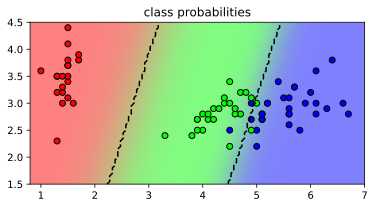

In [21]:
lr3classm

# Summary
- Two related linear classification models: Perceptron, Multi-class logistic regression
  - compute a linear function of input
  - non-linear output function (threshold or soft-max)
- We have assumed the inputs are feature vectors already.
  - What if we want to extract the features vectors too?